# GMM - Estimación de Densidad de Probabilidad y Muestreo

En éste notebook vamos a explorar las aplicaciones de los Gaussian Mixture Models a la estimación de densidad y muestreo.

## K-means vs. GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline
sns.set()

In [3]:
# Creamos un dataset stretch

X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

In [4]:
# Armamos una función para graficar los clusters de k-means y el neighborhood

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    
    labels = kmeans.fit_predict(X)
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.set_xlim(-8,2)
    ax.set_ylim(-2,8)
    centers = kmeans.cluster_centers_
    
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

/Users/panapelli/general/iia/current/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


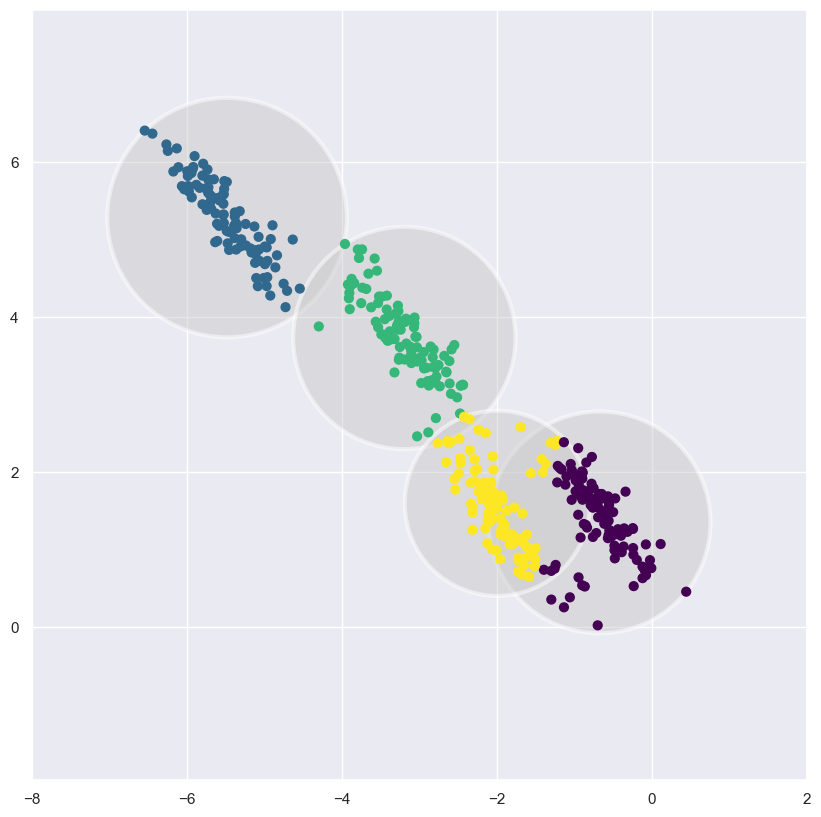

In [5]:
# Ajustamos K-means a los datos de entrada y graficamos

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In [6]:
# Comparamos con GMM

# Armamos funciones para graficar

def draw_ellipse(position, covariance, ax=None, **kwargs):

    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    labels = gmm.fit(X).predict(X)

    probs = gmm.predict_proba(X)

    size = 50 * probs.max(1) ** 2
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
        
    ax.axis('equal')
    ax.set_xlim(-8,2)
    ax.set_ylim(-2,8)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

/var/folders/qg/yd0f1vxs7ms4gcft0q12tytm0000gn/T/ipykernel_18896/328318840.py:19: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


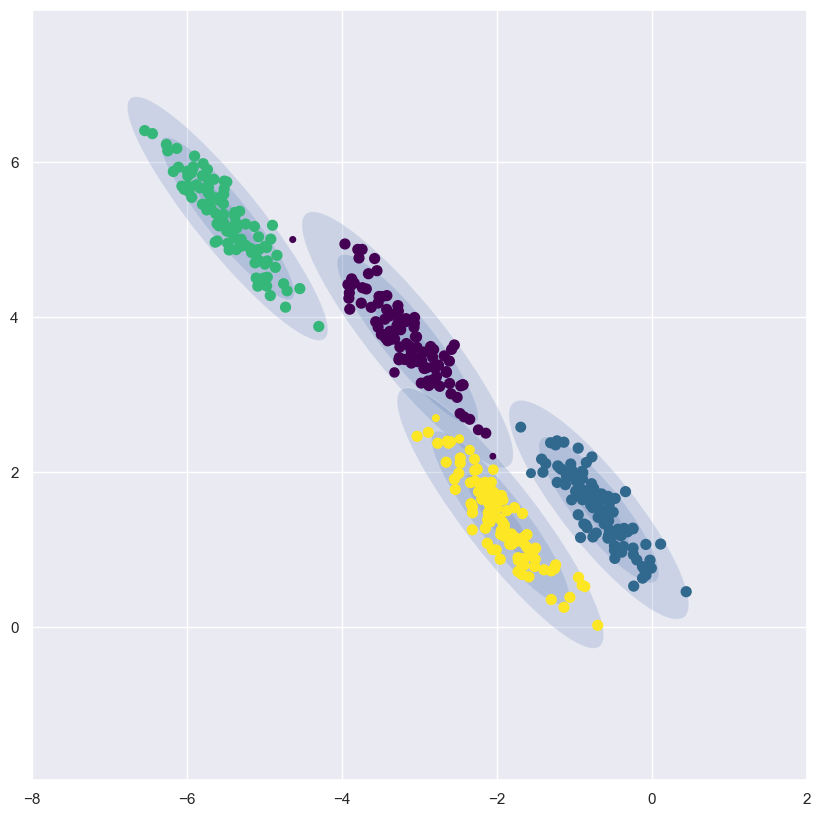

In [7]:
gm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)

plot_gmm(gm, X_stretched)

## Estimación Densidad de Probabilidad

La aplicación principal de GMM es poder realizar estimaciones de densidad de distribuciones de datos complejas multimodales. Esto nos permitirá, entre otras cosas, detectar anomalías (ver notebook).

In [8]:
X_moons, y_moons = make_moons(200, noise=0.05, random_state=2)

In [9]:
X_moons.shape, y_moons.shape

((200, 2), (200,))

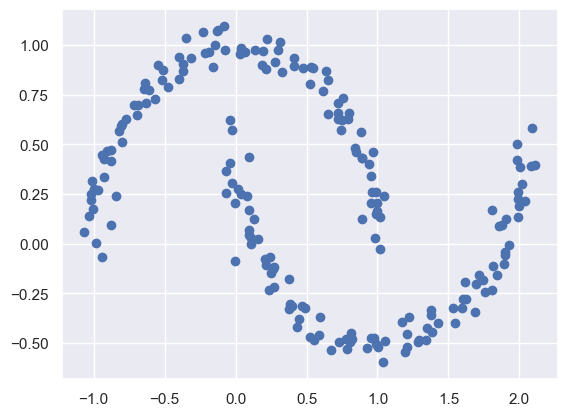

In [10]:
plt.scatter(X_moons[:, 0], X_moons[:, 1])
plt.show()

Como ven, es un dataset sintético complejo de clusterizar y clasificar. Nos vamos a enfocar en encontrar una estimación de densidad del conjunto de datos. Para encontrar el número óptimo de componentes del GMM, se pueden usar dos criterios de selección de modelos estadísticos como AIC (criterio de información de Akaike) y el BIC (criterio de información bayesiano), ambos relacionados con la cantidad de parámetros del modelo y con el valor máximo de la verosimilitud. Mientras más bajo sea el valor mejor.

$AIC = -2log(\hat{L}) + 2d$

Donde $\hat{L}$ es la maxima verosimilitud del modelo y $d$ la cantidad de parámetros.

$BIC = -2log(\hat{L}) + log(N)d$

Con $N$: cantidad de observaciones. 

Para un modelo lineal gaussiano se tiene:

$log(\hat{L}) = -\frac{n}{2}log(2\pi) - \frac{n}{2}ln(\sigma^2) - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{2\sigma^2}$

Text(0.5, 0, 'n_components')

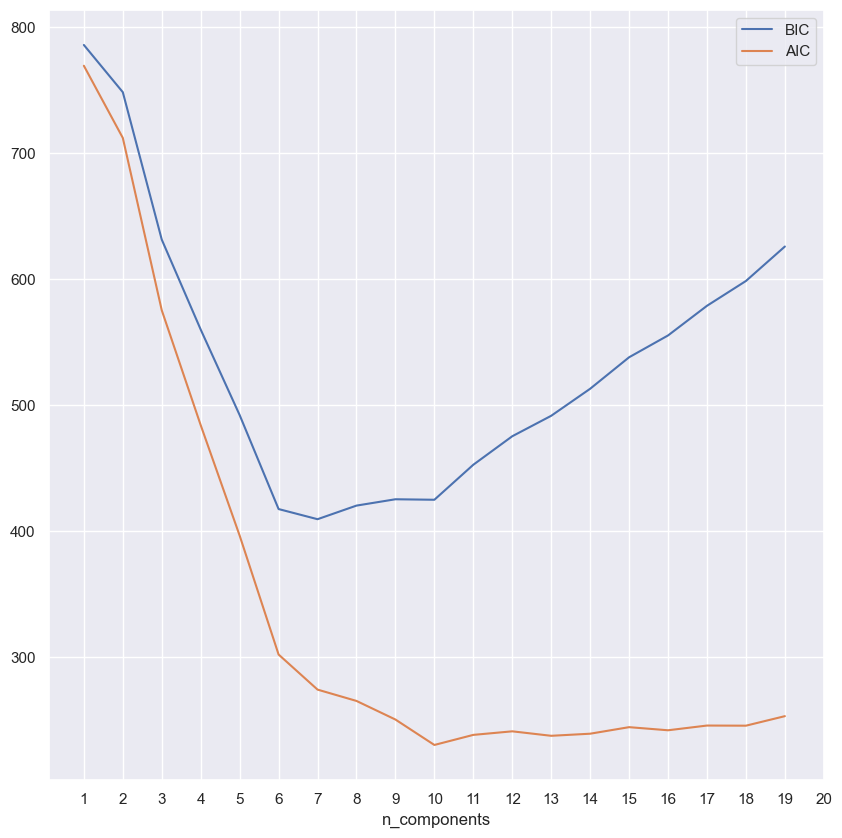

In [11]:
# Seleccionamos la cantidad de componentes a probar
n_components = np.arange(1, 20)

# Armamos un modelo por cada cantidad de componentes (se puede probar con distintos tipos de covarianza)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_moons)
          for n in n_components]

plt.figure(figsize=(10, 10))
plt.plot(n_components, [m.bic(X_moons) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_moons) for m in models], label='AIC')
plt.gca().set_xticks(range(1, 21,1))
plt.legend(loc='best')
plt.xlabel('n_components')

/var/folders/qg/yd0f1vxs7ms4gcft0q12tytm0000gn/T/ipykernel_18896/328318840.py:19: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


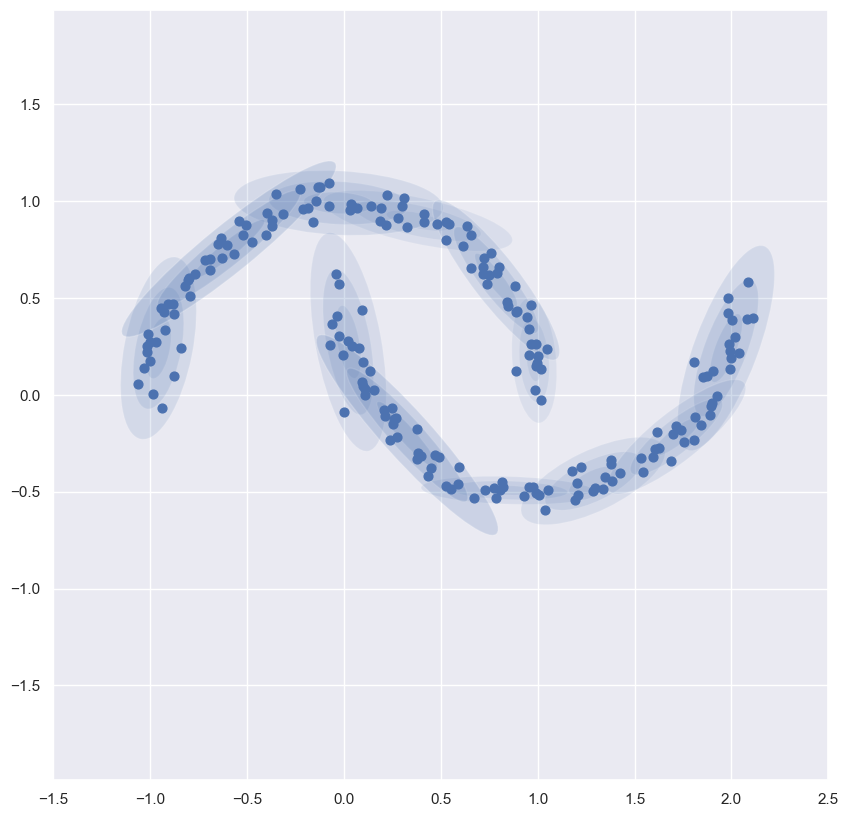

In [12]:
gm_12 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)

plot_gmm(gm_12, X_moons, label=False)
plt.gca().set_xlim(-1.5,2.5)
plt.gca().set_ylim(-1.5,1.5)
plt.show()

## Sampling

A partir del ejemplo anterior, podríamos pensar en utilizar la estimación de densidad de probabilidad para generar nuevas muestras. Esto equivale en el modelo de variables latentes a seleccionar un determinado valor de la variable y continuar con el proceso.

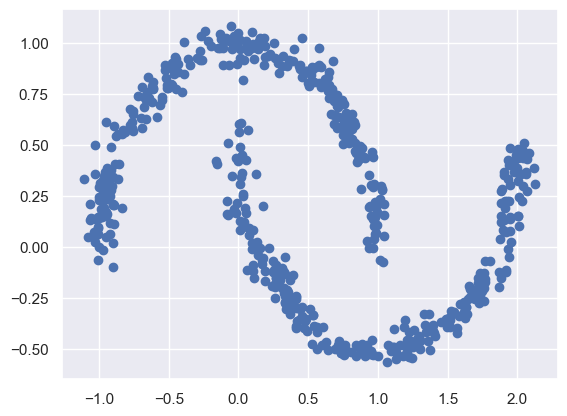

In [13]:
# Generamos muestras nuevas de la distribución anterior

X_muestreo, _ = gm_12.sample(600)

plt.scatter(X_muestreo[:, 0], X_muestreo[:, 1])
plt.show()

### Sampling Dataset de Dígitos

Vamos a continuar con el dataset de dígitos de la clase 2 (PCA) y clase 6 (Softmax), para plantear un modelo GMM de ajuste e intentar muestrear nuevos dígitos.

In [14]:
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


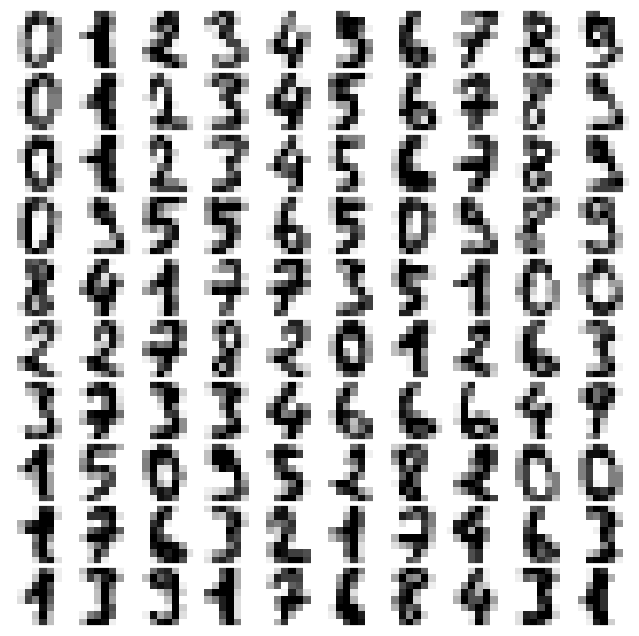

In [15]:
# Armamos una función para graficar n cantidad de dígitos

def plot_digits(data, n=100):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(X)

In [16]:
# Para evitar problemas de convergencia de GMM por alta dimensionalidad, vamos a aplicar PCA como en ejercicio de la Clase 2.

pca = PCA(0.9, whiten=True)

X_pca = pca.fit_transform(X)

X_pca.shape

(1797, 21)

Text(0.5, 0, 'n_components')

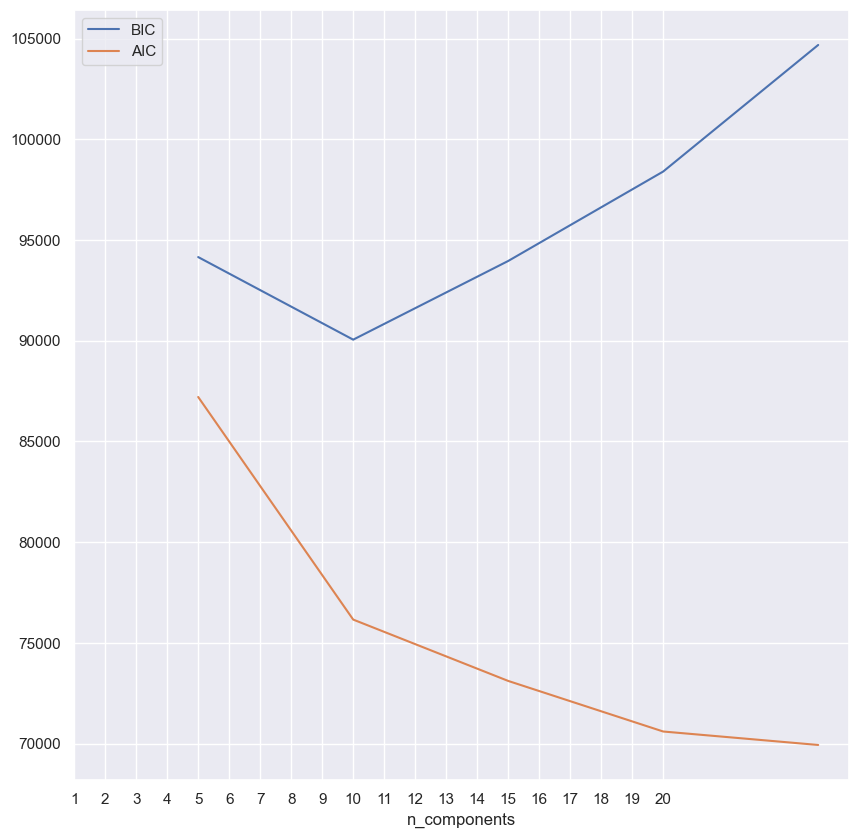

In [17]:
# Seleccionamos la cantidad de componentes a probar
n_components = np.arange(5, 30, 5)

# Armamos un modelo por cada cantidad de componentes (se puede probar con distintos tipos de covarianza)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca)
          for n in n_components]

plt.figure(figsize=(10, 10))
plt.plot(n_components, [m.bic(X_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pca) for m in models], label='AIC')
plt.gca().set_xticks(range(1, 21,1))
plt.legend(loc='best')
plt.xlabel('n_components')

In [18]:
# TODO: Revisar el AIC y el BIC para elegir la cantidad de componentes.

gmm = GaussianMixture(20, covariance_type='full', random_state=0)

gmm.fit(X_pca)

print(gmm.converged_)

True


In [19]:
# Muestreamos nuevos datos al igual que en el ejemplo anterior

X_muestreo, _ = gmm.sample(100)

X_muestreo.shape

(100, 21)

In [20]:
X_muestreo = pca.inverse_transform(X_muestreo)

In [21]:
gmm.weights_

array([0.04314411, 0.02937814, 0.04727916, 0.05508827, 0.04621385,
       0.06177354, 0.04351488, 0.05677375, 0.04897842, 0.02558451,
       0.05788515, 0.06396781, 0.04947798, 0.08682185, 0.06926686,
       0.04672111, 0.03728066, 0.03446397, 0.07134529, 0.02504071])

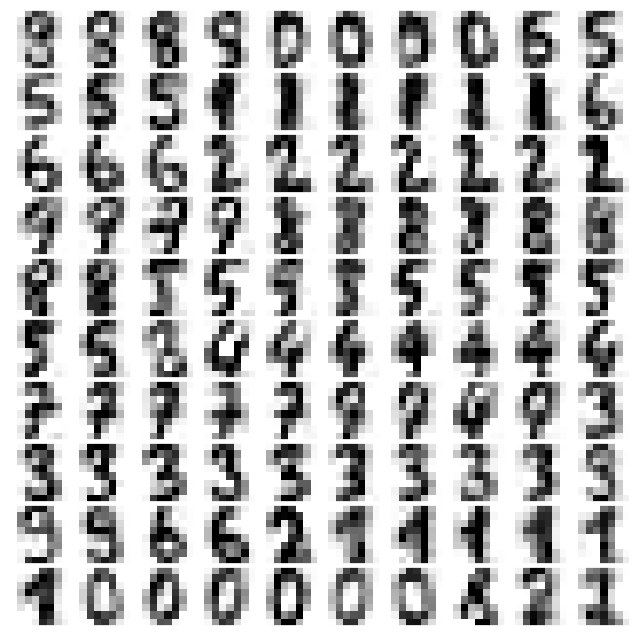

In [22]:
plot_digits(X_muestreo)

In [23]:
gmm = GaussianMixture(10, covariance_type='full', random_state=0)

gmm.fit(X_pca)

print(gmm.converged_)

True


In [24]:
# Muestreamos nuevos datos al igual que en el ejemplo anterior

X_muestreo, _ = gmm.sample(100)

X_muestreo.shape

(100, 21)

In [25]:
X_muestreo = pca.inverse_transform(X_muestreo)

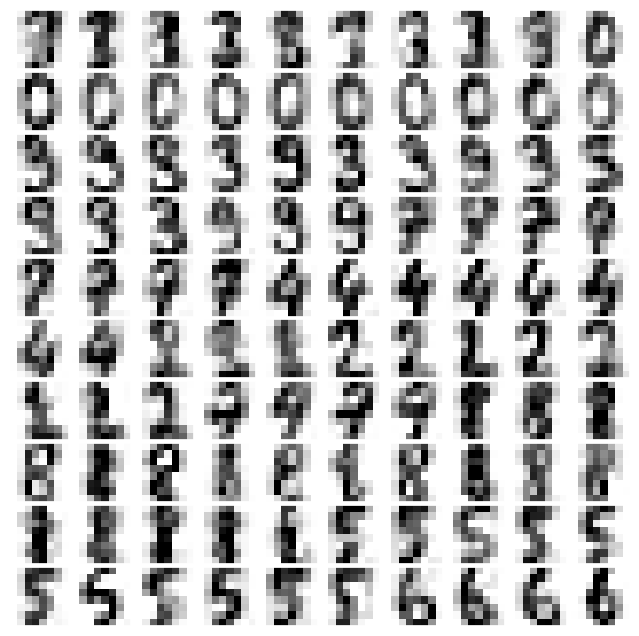

In [26]:
plot_digits(X_muestreo)

---

## Bibliografía

* In Depth: Gaussian Mixture Models. Python Data Science Handbook by Jake VanderPlas